In [1]:
import os

os.environ["LL_DISABLE_TYPECHECKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"


import ll
import rich
import torch

ll.pretty(lovely_numpy=False)


# torch.no_grad().__enter__()
# torch.inference_mode().__enter__()

TensorBoard/TensorBoardX not found. Disabling TensorBoardLogger. Please install TensorBoard with `pip install tensorboard` or TensorBoardX with `pip install tensorboardx` to enable TensorBoard logging.


In [5]:
from jmppeft.modules.dataset.common import DatasetSampleNConfig
from jmppeft.tasks.finetune.base import FinetuneMatBenchDiscoveryIS2REDatasetConfig

dataset_config = FinetuneMatBenchDiscoveryIS2REDatasetConfig(
    sample_n=DatasetSampleNConfig(sample_n=16, seed=42)
)
print(dataset_config)

dataset_og = dataset_config.create_dataset()
dataset_og, len(dataset_og)

sample_n=DatasetSampleNConfig(sample_n=16, seed=42)


(<jmppeft.datasets.mpd_is2re.MatBenchDiscoveryIS2REDataset at 0x7fb138477790>,
 256963)

In [2]:
from pathlib import Path

ckpt_path = Path(
    "/net/csefiles/coc-fung-cluster/nima/shared/experiment-data/lltrainer/lmmtlw3j/checkpoint/last.ckpt"
)
ckpt_path

Path('/net/csefiles/coc-fung-cluster/nima/shared/experiment-data/lltrainer/lmmtlw3j/checkpoint/last.ckpt')

In [3]:
from jmppeft.tasks.finetune import matbench_discovery as M

model = M.MatbenchDiscoveryModel.load_from_checkpoint(ckpt_path, map_location="cuda")
model

[15:52:45] CRITICAL Type checking is disabled due to the environment variable                       ]8;id=898863;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/ll/src/ll/typecheck.py\typecheck.py]8;;\:]8;id=902426;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/ll/src/ll/typecheck.py#55\55]8;;\
                    LL_DISABLE_TYPECHECKING.                                                                       

[15:52:46] INFO     PyTorch version 2.2.2 available.                                                   ]8;id=44342;file:///net/csefiles/coc-fung-cluster/nima/miniforge3/envs/jmp-peft/lib/python3.11/site-packages/datasets/config.py\config.py]8;;\:]8;id=756282;file:///net/csefiles/coc-fung-cluster/nima/miniforge3/envs/jmp-peft/lib/python3.11/site-packages/datasets/config.py#58\58]8;;\

In [4]:
from mace.calculators import mace_mp

default_dtype = torch.float64
mace = mace_mp(
    "large",
    device=str(model.device),
    default_dtype=str(default_dtype).rsplit(".", 1)[-1],
)
mace

Using Materials Project MACE for MACECalculator with /nethome/nsg6/.cache/mace/5f5yavf3
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


[15:52:55] INFO     CUDA version: 12.1, CUDA device: 0                                            ]8;id=317872;file:///net/csefiles/coc-fung-cluster/nima/miniforge3/envs/jmp-peft/lib/python3.11/site-packages/mace/tools/torch_tools.py\torch_tools.py]8;;\:]8;id=1342;file:///net/csefiles/coc-fung-cluster/nima/miniforge3/envs/jmp-peft/lib/python3.11/site-packages/mace/tools/torch_tools.py#58\58]8;;\

In [13]:
from collections import Counter

import jmppeft.modules.dataset.dataset_transform as DT
import torch.utils._pytree as tree
from lightning.fabric.utilities.apply_func import move_data_to_device
from torch_geometric.data import Batch, Data


def data_transform(data: Data):
    data = model.data_transform(data)
    data = Data.from_dict(
        tree.tree_map(
            lambda x: x.type(default_dtype)
            if torch.is_tensor(x) and torch.is_floating_point(x)
            else x,
            data.to_dict(),
        )
    )
    return data


def composition(data: Batch):
    return dict(Counter(data.atomic_numbers.tolist()))


num_items = 512

dataset = DT.transform(dataset_og, data_transform)
dataset = DT.sample_n_transform(dataset, n=num_items, seed=42)


idx = 32
data = Batch.from_data_list([dataset[idx]])
rich.print(
    data.to_dict(),
    composition(data),
)

{
    'pos': tensor[9, 3] f64 n=27 x∈[-2.210, 4.419] μ=1.312 σ=1.728,
    'id': ['wbm-3-75654'],
    'atomic_numbers': tensor[9] i64 x∈[23, 49] μ=33.000 σ=12.124 [23, 23, 23, 49, 49, 49, 27, 27, 27],
    'cell': tensor[1, 3, 3] f64 n=9 x∈[-3.562, 7.124] μ=1.427 σ=3.407 [[[3.110, 0., 1.904e-16], [9.921e-16, 6.169, 
-3.562], [0., 0., 7.124]]],
    'y_formation': tensor[1] f64 [0.166],
    'y_formation_correction': tensor[1] f64 [0.],
    'y_above_hull': tensor[1] f64 [0.289],
    'natoms': tensor[1] i64 [9],
    'tags': tensor[9] i64 x∈[2, 2] μ=2.000 σ=0. [2, 2, 2, 2, 2, 2, 2, 2, 2],
    'fixed': tensor[9] bool all_zeros [False, False, False, False, False, False, False, False, False],
    'batch': tensor[9] i64 all_zeros [0, 0, 0, 0, 0, 0, 0, 0, 0],
    'ptr': tensor[2] i64 μ=4.500 σ=6.364 [0, 9]
}
{23: 3, 49: 3, 27: 3}

In [1]:
import copy

from jmppeft.modules.relaxer import ModelOutput, Relaxer
from matbench_discovery.energy import get_e_form_per_atom


def model_fn(data, initial_data) -> ModelOutput:
    # model_out = model.forward_denormalized(data)

    atoms = copy.deepcopy(Relaxer._graph_to_atoms(data))
    atoms.calc = mace

    # energy = model_out["y"]
    energy = torch.tensor(atoms.get_total_energy(), dtype=default_dtype)
    # forces = model_out["force"]
    forces = torch.tensor(atoms.get_forces(), dtype=default_dtype)
    # stress = model_out["stress"]
    stress = torch.tensor(atoms.get_stress(), dtype=default_dtype)
    if stress.shape == (6,):
        # Convert to 3x3 stress tensor
        stress_matrix = torch.tensor(
            [
                [stress[0], stress[3], stress[4]],
                [stress[3], stress[1], stress[5]],
                [stress[4], stress[5], stress[2]],
            ],
            dtype=default_dtype,
        )
        stress = stress_matrix

    # This energy is DFT total energy, we need to convert it to formation energy per atom
    energy = get_e_form_per_atom(
        {
            "composition": composition(data),
            "energy": energy,
        }
    )
    assert isinstance(energy, torch.Tensor)

    # Add the correction factor
    if True:
        energy += initial_data.y_formation_correction.item()

    energy = energy.view(1)
    forces = forces.view(-1, 3)
    stress = stress.view(1, 3, 3) if stress.numel() == 9 else stress.view(1, 6)

    return {
        "energy": energy,
        "forces": forces,
        "stress": stress,
    }


model_fn(data, data)

KeyboardInterrupt: 

In [15]:
from jmppeft.modules.relaxer import RelaxerConfig

config = RelaxerConfig(
    compute_stress=True,
    stress_weight=0.1,
    optimizer="FIRE",
    fmax=0.05,
)
relaxer = Relaxer(
    config=config,
    model=model_fn,
    collate_fn=model.collate_fn,
    device=model.device,
)
rich.print(data.y_formation)
relax_out = relaxer.relax(data)
# rich.print(relax_out)

energy = relax_out.atoms.get_total_energy()
rich.print(energy, data.y_formation)

tensor[1] f64 [0.166]

      Step     Time          Energy          fmax
FIRE:    0 15:57:23        0.230572        0.320421


FIRE:    1 15:57:23        0.230211        0.310809
FIRE:    2 15:57:23        0.229525        0.292032
FIRE:    3 15:57:23        0.228582        0.264970
FIRE:    4 15:57:23        0.227475        0.230866
FIRE:    5 15:57:23        0.226314        0.191202
FIRE:    6 15:57:23        0.225218        0.147560
FIRE:    7 15:57:23        0.224306        0.101426
FIRE:    8 15:57:23        0.223651        0.048886


0.22365068321596324 tensor[1] f64 [0.166]

In [9]:
from collections import defaultdict

import numpy as np
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

config = RelaxerConfig(
    compute_stress=True,
    stress_weight=0.1,
    optimizer="FIRE",
    fmax=0.05,
    steps=500,
)
relaxer = Relaxer(
    config=config,
    model=model_fn,
    collate_fn=model.collate_fn,
    device=model.device,
)

dl = DataLoader(
    dataset,
    batch_size=1,
    collate_fn=model.collate_fn,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

preds_targets = defaultdict[str, list[tuple[float, float]]](lambda: [])
for data in tqdm(dl, total=len(dl)):
    data = move_data_to_device(data, model.device)
    relax_out = relaxer.relax(data)

    e_form_true = data.y_formation.item()
    e_form_pred = relax_out.atoms.get_total_energy()
    preds_targets["e_form"].append((e_form_pred, e_form_true))

    e_above_hull_true = data.y_above_hull.item()
    e_above_hull_pred = e_above_hull_true + (e_form_pred - e_form_true)
    preds_targets["e_above_hull"].append((e_above_hull_pred, e_above_hull_true))

  0%|          | 0/128 [00:00<?, ?it/s]

      Step     Time          Energy          fmax
FIRE:    0 15:49:09       -0.364941        0.170888
FIRE:    1 15:49:09       -0.365078        0.163957
FIRE:    2 15:49:09       -0.365325        0.150429
FIRE:    3 15:49:09       -0.365636        0.130955
FIRE:    4 15:49:09       -0.365953        0.106476
FIRE:    5 15:49:09       -0.366222        0.078228
FIRE:    6 15:49:09       -0.366409        0.047900
      Step     Time          Energy          fmax
FIRE:    0 15:49:09       -0.002077        0.383584
FIRE:    1 15:49:10       -0.002514        0.379518
FIRE:    2 15:49:10       -0.003371        0.371285
FIRE:    3 15:49:10       -0.004613        0.358560
FIRE:    4 15:49:10       -0.006187        0.340530
FIRE:    5 15:49:10       -0.008020        0.315526
FIRE:    6 15:49:10       -0.010001        0.280743
FIRE:    7 15:49:10       -0.011971        0.232512
FIRE:    8 15:49:10       -0.013861        0.159605
FIRE:    9 15:49:10       -0.015171        0.054637
FIRE:   10 15:49

In [10]:
import pickle

base_save_dir = Path("/net/csefiles/coc-fung-cluster/nima/relaxation-dump-7-4/mace-v7/")
base_save_dir.mkdir(parents=True, exist_ok=True)

with (base_save_dir / "preds_targets.pkl").open("wb") as f:
    pickle.dump(dict(preds_targets), f)

In [13]:
e_form_true, e_form_pred = zip(*preds_targets["e_form"])
e_form_true = np.array(e_form_true)
e_form_pred = np.array(e_form_pred)

e_above_hull_true, e_above_hull_pred = zip(*preds_targets["e_above_hull"])
e_above_hull_true = np.array(e_above_hull_true)
e_above_hull_pred = np.array(e_above_hull_pred)

rich.print(
    {
        "e_form": {"pred": e_form_pred, "true": e_form_true},
        "e_above_hull": {"pred": e_above_hull_pred, "true": e_above_hull_true},
    }
)

{
    'e_form': {
        'pred': array([-3.39213014e-01, -2.69169994e-02, -9.08369005e-01, -5.49326003e-01,
       -5.86207986e-01, -7.65179992e-02, -3.22719991e-01,  1.94119006e-01,
        2.91216999e-01,  6.77189976e-02, -7.25170016e-01, -4.83552992e-01,
       -1.93983996e+00, -1.32273003e-01, -1.39774993e-01, -2.15544701e+00,
       -5.54596007e-01, -1.50520995e-01, -1.70642003e-01, -5.25600016e-01,
       -3.79471004e-01, -6.99589998e-02,  6.42400011e-02,  4.42176014e-01,
       -3.25703692e+00, -1.67422998e+00, -3.09600592e+00, -9.32738006e-01,
        9.77820009e-02, -2.85851985e-01, -6.79552019e-01,  7.15219975e-02,
       -2.39473000e-01, -7.01910973e-01, -8.99710000e-01, -1.59264696e+00,
       -5.17165005e-01, -3.29485989e+00, -4.60642010e-01, -4.47665989e-01,
       -3.15247107e+00, -5.74415028e-01, -5.56870997e-01, -1.97447002e-01,
       -3.15032101e+00, -4.19494003e-01, -1.04690802e+00, -6.74456000e-01,
       -1.72159001e-01, -4.66477990e-01, -4.52950001e-01, -3.87297988e-01,
        3.46600008e-03, -3.17223406e+00, -6.24301016e-01,  9.52040032e-02,
       -1.46470404e+00, -3.65375996e-01,  2.11942002e-01, -1.76101997e-01,
       -2.96576309e+00, -2.22117710e+00, -9.60327029e-01, -2.86881000e-01,
       -2.02373505e+00, -1.44769895e+00, -4.50082004e-01, -9.98679996e-02,
        3.06070000e-02, -1.15020597e+00, -5.32829985e-02, -2.80337691e+00,
       -9.39854026e-01, -6.03327990e-01, -7.93111026e-01, -1.41195798e+00,
       -4.67303991e-01, -2.49228811e+00,  8.20920020e-02, -1.76229998e-01,
       -1.04372001e+00, -3.00104690e+00, -2.72837013e-01, -1.02336299e+00,
       -1.00787604e+00, -2.02745509e+00, -1.12939000e-01, -3.79475093e+00,
       -1.04911304e+00, -7.89500028e-02, -6.96488976e-01, -6.59906030e-01,
       -3.08257014e-01, -3.24039012e-01, -3.58790994e-01, -4.18994993e-01,
       -1.53870001e-01, -8.12574029e-01,  6.84389994e-02, -1.66137993e-01,
       -2.95462012e-01,  1.13169998e-01, -5.05740009e-02, -5.07300012e-02,
       -2.73434013e-01, -4.52461004e-01, -4.72956002e-01, -2.64013195e+00,
       -3.70921993e+00, -6.25370979e-01, -3.07325989e-01, -2.32420005e-02,
        3.11251998e-01, -1.16732597e+00,  2.94737011e-01, -2.96968013e-01,
       -1.06331003e+00, -9.96610001e-02, -5.16004980e-01, -2.91891009e-01,
       -1.54940498e+00, -2.20142007e-01, -4.81927991e-01, -2.41223007e-01,
       -6.07186019e-01, -4.23467994e-01,  2.63509993e-02, -1.73865104e+00]),
        'true': array([-3.66408827e-01, -1.53842139e-02, -8.39989731e-01, -5.09952949e-01,
       -5.69520226e-01, -1.89094180e-01, -2.92230805e-01,  2.31989081e-01,
        2.58645394e-01,  1.12377081e-01, -7.60959735e-01, -4.95528384e-01,
       -1.88922419e+00, -1.05657463e-01, -8.91161173e-02, -2.16879162e+00,
       -5.71242047e-01, -9.58733362e-02, -1.58272723e-01, -3.07694440e-01,
       -2.61905262e-01,  7.56182545e-01,  1.06400625e-01,  6.35589480e-01,
       -3.15682650e+00, -1.43647327e+00, -3.19921911e+00,  1.39863536e-01,
        2.06527773e-01, -2.31529407e-01, -6.53273849e-01,  1.06052052e-01,
       -1.38113559e-01, -6.69369368e-01, -7.33862375e-01, -1.63665030e+00,
       -3.53822605e-01, -3.20714089e+00, -4.64522693e-01, -4.21826620e-01,
       -3.18509006e+00, -5.57607529e-01, -6.42585614e-01,  1.85558784e-01,
       -2.83804718e+00, -4.45172220e-01, -1.03187801e+00, -7.83239652e-01,
       -6.85185674e-02, -4.33972819e-01, -2.95358799e-02, -4.62992023e-01,
        2.36480568e-01, -3.15288604e+00, -6.36745146e-01,  1.22445240e-01,
       -1.62640649e+00, -4.22630776e-01,  3.39008977e-01, -1.68050324e-01,
       -2.89869755e+00, -2.19266386e+00, -8.86327259e-01, -3.68774510e-01,
       -2.14252734e+00, -1.91472800e+00, -5.20674860e-01, -2.23450173e-01,
        1.21244813e-01, -1.15203464e+00, -1.19347854e-01, -2.77257811e+00,
       -8.63985211e-01, -4.89519199e-01, -7.63067411e-01, -1.20527897e+00,
       -4.87672126e-01, -2.31229475e+00,  5.07119709e-01, -1.09087410e-01,
       -1.12170049e+00, -2.79479197e+00, -2.2119

/tmp/ipykernel_939300/3869410676.py:20: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


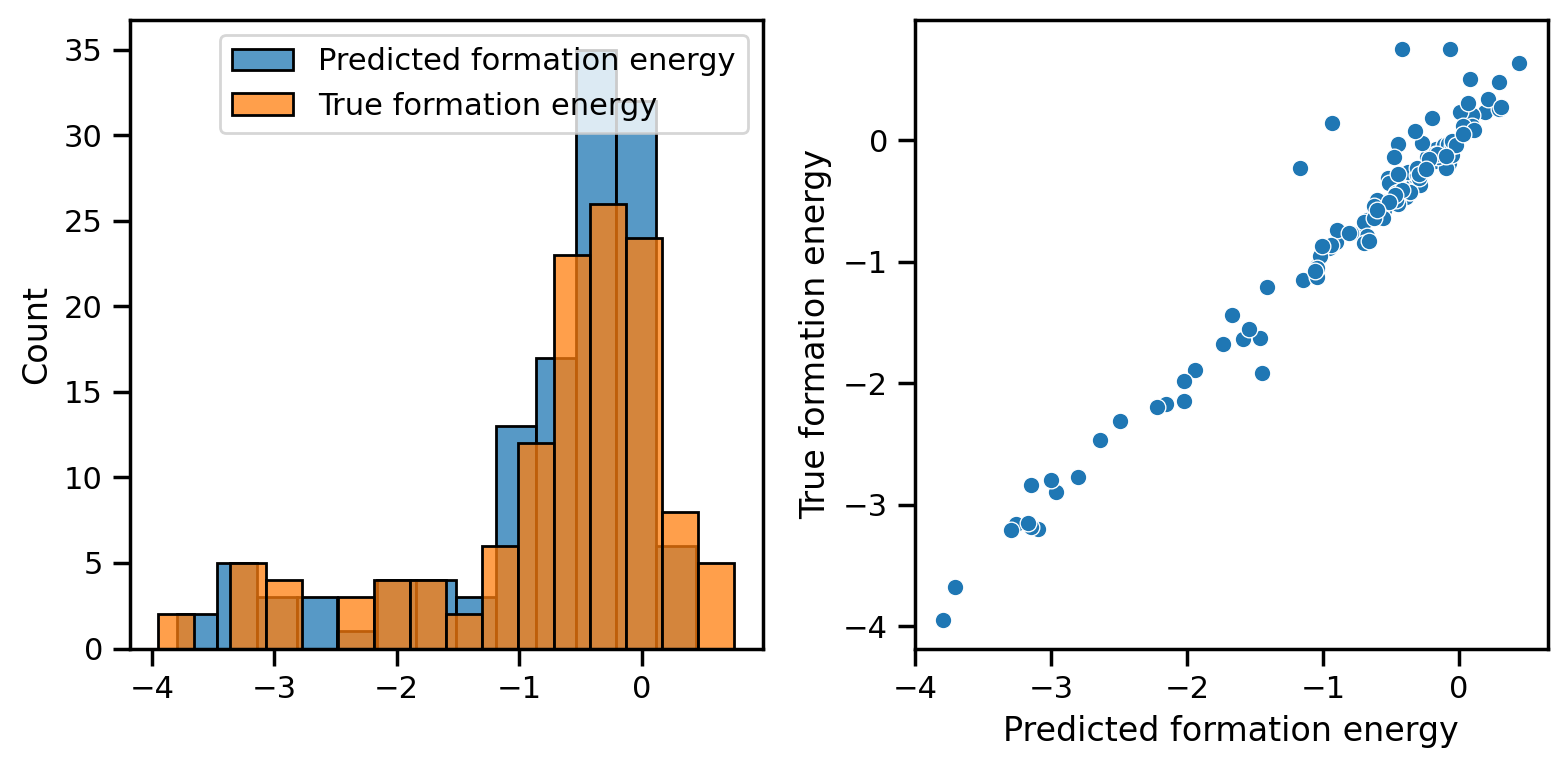

{
    'F1': 0.5625,
    'DAF': 4.663967611336032,
    'Precision': 0.47368421052631576,
    'Recall': 0.6923076923076923,
    'Accuracy': 0.890625,
    'TPR': 0.6923076923076923,
    'FPR': 0.08695652173913043,
    'TNR': 0.9130434782608695,
    'FNR': 0.3076923076923077,
    'TP': 9,
    'FP': 10,
    'TN': 105,
    'FN': 4,
    'MAE': 0.11738410378240548,
    'RMSE': 0.22061159350777754,
    'R2': 0.13384283882906955
}

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from matbench_discovery.metrics import stable_metrics

sns.set_context("notebook")

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes = axes.flatten()

ax = axes[0]
sns.histplot(e_form_pred, label="Predicted formation energy", ax=ax)
sns.histplot(e_form_true, label="True formation energy", ax=ax)
ax.legend()

ax = axes[1]
sns.scatterplot(y=e_form_true, x=e_form_pred, ax=ax)
ax.set_xlabel("Predicted formation energy")
ax.set_ylabel("True formation energy")

fig.tight_layout()
plt.show()

metrics = stable_metrics(e_above_hull_true, e_above_hull_pred, fillna=False)
rich.print(metrics)